In [1]:
import numpy as np
import pandas as pd
import shap

from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


from sklearn.svm import SVC

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
df = pd.read_csv("features_model_ready.csv")

print(df.shape)
df.head()

(2084, 19)


,subject,imu_accmag_mean,imu_accmag_std,imu_accmag_max,imu_accmag_p95,imu_gyromag_mean,imu_gyromag_std,imu_gyromag_max,imu_gyromag_p95,emg_ch0_env_mean,emg_ch0_env_std,emg_ch0_env_max,emg_ch0_env_p95,emg_global_env_mean,emg_global_env_std,emg_global_env_max,emg_global_env_p95,exercise_type,is_correct
0,1,0.999222,0.098902,1.442623,1.131357,60.443236,58.447196,166.830407,159.905001,0.011200,0.010289,0.037874,0.033728,0.012837,0.009930,0.041420,0.033819,squat,1
1,1,1.002206,0.103702,1.338406,1.146115,56.855660,54.704870,234.507940,139.115841,0.009190,0.007733,0.032042,0.024040,0.012490,0.011031,0.048033,0.036518,squat,1
2,1,1.000151,0.080868,1.268263,1.105984,57.721283,55.116663,170.564664,150.306468,0.010828,0.009748,0.036509,0.031314,0.013111,0.010204,0.037347,0.030871,squat,1
3,1,1.003110,0.094185,1.230914,1.118336,59.007138,57.124420,216.115219,147.677125,0.010438,0.010127,0.043413,0.034380,0.014028,0.011856,0.046266,0.036993,squat,1
4,1,1.003883,0.086680,1.233887,1.101139,57.815528,54.620345,207.762999,141.153516,0.009087,0.008685,0.035427,0.027361,0.011306,0.008768,0.031054,0.028314,squat,1


In [3]:
features_df_squat = df[df["exercise_type"] == "squat"].copy()
features_df_sle = df[df["exercise_type"] == "sle"].copy()
features_df_walking = df[df["exercise_type"] == "walking"].copy()

features_df_squat = features_df_squat.drop(columns="exercise_type", errors="ignore")
features_df_sle = features_df_sle.drop(columns="exercise_type", errors="ignore")
features_df_walking = features_df_walking.drop(columns="exercise_type", errors="ignore")

In [4]:
features_df = df.drop(columns="exercise_type", errors="ignore")
features_df.columns.tolist()

['subject',
 'imu_accmag_mean',
 'imu_accmag_std',
 'imu_accmag_max',
 'imu_accmag_p95',
 'imu_gyromag_mean',
 'imu_gyromag_std',
 'imu_gyromag_max',
 'imu_gyromag_p95',
 'emg_ch0_env_mean',
 'emg_ch0_env_std',
 'emg_ch0_env_max',
 'emg_ch0_env_p95',
 'emg_global_env_mean',
 'emg_global_env_std',
 'emg_global_env_max',
 'emg_global_env_p95',
 'is_correct']

In [5]:
# X e y (binario)
y = features_df["is_correct"]

# Columnas que NO deben entrar en el modelo (fuga / metadata / rutas)
forbidden_cols = [
    "exercise_id",
    "trial",
    "imu_len",
    "emg_len",
    "len_ratio_emg_imu",
    "imu_path",
    "emg_path",
    "imu_shape",
    "emg_shape",
    "imu_exists",
    "emg_exists",
]

# Construimos X como el dataframe de features (sin esas columnas)
X = features_df.drop(columns=["subject", "is_correct"] + forbidden_cols, errors="ignore")

print("features_df columns:", X.columns.tolist())

features_df columns: ['imu_accmag_mean', 'imu_accmag_std', 'imu_accmag_max', 'imu_accmag_p95', 'imu_gyromag_mean', 'imu_gyromag_std', 'imu_gyromag_max', 'imu_gyromag_p95', 'emg_ch0_env_mean', 'emg_ch0_env_std', 'emg_ch0_env_max', 'emg_ch0_env_p95', 'emg_global_env_mean', 'emg_global_env_std', 'emg_global_env_max', 'emg_global_env_p95']


In [6]:
models = {
    "LogReg": LogisticRegression(max_iter=2000, random_state=42),
    "RF": RandomForestClassifier(n_estimators=300, random_state=42),
    "SVM-linear": SVC(kernel="linear", probability=True),
    "SVM-rbf": SVC(kernel="rbf", probability=True),
    # "ExtraTrees": ExtraTreesClassifier(n_estimators=500, random_state=42),
    # "GradBoost": GradientBoostingClassifier(random_state=42),
    # "AdaBoost": AdaBoostClassifier(n_estimators=300,random_state=42),
    # "LDA" : LinearDiscriminantAnalysis()
}

In [7]:
def run_loso(features_df, models):
    results = []

    subjects = sorted(features_df["subject"].unique())

    for subj in subjects:
        train_df = features_df[features_df.subject != subj]
        test_df  = features_df[features_df.subject == subj]

        
        X_train = train_df.drop(columns=["subject", "is_correct"] + forbidden_cols, errors="ignore")
        y_train = train_df["is_correct"]

        X_test  = test_df.drop(columns=["subject", "is_correct"] + forbidden_cols, errors="ignore")
        y_test  = test_df["is_correct"]

        for model_name, model in models.items():
            pipe = Pipeline([
                ("scaler", StandardScaler()),
                ("clf", model),
            ])

            pipe.fit(X_train, y_train)
            preds = pipe.predict(X_test)

            acc   = accuracy_score(y_test, preds)
            f1    = f1_score(y_test, preds, average="macro")
            kappa = cohen_kappa_score(y_test, preds)

            results.append({
                "subject_left_out": subj,
                "model": model_name,
                "accuracy": acc,
                "macro_f1": f1,
                "kappa": kappa
            })

            print(f"Subj {subj:02d} | {model_name} → acc={acc:.3f}, f1={f1:.3f}, kappa={kappa:.3f}")

    return pd.DataFrame(results)

In [8]:
results_loso = run_loso(features_df, models)
results_loso

Subj 01 | LogReg → acc=0.528, f1=0.430, kappa=-0.128
Subj 01 | RF → acc=0.283, f1=0.262, kappa=-0.183
Subj 01 | SVM-linear → acc=0.547, f1=0.388, kappa=-0.167
Subj 01 | SVM-rbf → acc=0.377, f1=0.354, kappa=-0.268
Subj 02 | LogReg → acc=0.611, f1=0.379, kappa=0.000
Subj 02 | RF → acc=0.630, f1=0.429, kappa=0.058
Subj 02 | SVM-linear → acc=0.611, f1=0.379, kappa=0.000
Subj 02 | SVM-rbf → acc=0.611, f1=0.379, kappa=0.000
Subj 03 | LogReg → acc=0.606, f1=0.459, kappa=0.108
Subj 03 | RF → acc=0.690, f1=0.660, kappa=0.341
Subj 03 | SVM-linear → acc=0.592, f1=0.428, kappa=0.072
Subj 03 | SVM-rbf → acc=0.563, f1=0.360, kappa=0.000
Subj 04 | LogReg → acc=0.632, f1=0.419, kappa=0.042
Subj 04 | RF → acc=0.605, f1=0.474, kappa=0.036
Subj 04 | SVM-linear → acc=0.618, f1=0.382, kappa=0.000
Subj 04 | SVM-rbf → acc=0.632, f1=0.419, kappa=0.042
Subj 05 | LogReg → acc=0.611, f1=0.611, kappa=0.232
Subj 05 | RF → acc=0.444, f1=0.441, kappa=-0.118
Subj 05 | SVM-linear → acc=0.611, f1=0.611, kappa=0.227
Sub

,subject_left_out,model,accuracy,macro_f1,kappa
0,1,LogReg,0.528302,0.430108,-0.127660
1,1,RF,0.283019,0.261730,-0.183314
2,1,SVM-linear,0.547170,0.388462,-0.166972
3,1,SVM-rbf,0.377358,0.354374,-0.268310
4,2,LogReg,0.611111,0.379310,0.000000
...,...,...,...,...,...
119,30,SVM-rbf,0.687500,0.684729,0.416058
120,31,LogReg,0.776119,0.494721,0.068582
121,31,RF,0.597015,0.433448,-0.132749
122,31,SVM-linear,0.776119,0.494721,0.068582


In [9]:
results_loso.to_csv("results_loso_baselines.csv", index=False)

In [10]:
model_summary = (
    results_loso
    .groupby("model")
    .agg(
        n_subjects = ("subject_left_out", "nunique"),
        acc_mean   = ("accuracy", "mean"),
        acc_std    = ("accuracy", "std"),
        f1_mean    = ("macro_f1", "mean"),
        f1_std     = ("macro_f1", "std"),
        kappa_mean = ("kappa", "mean"),
        kappa_std  = ("kappa", "std"),
    )
    .reset_index()
)

model_summary

,model,n_subjects,acc_mean,acc_std,f1_mean,f1_std,kappa_mean,kappa_std
0,LogReg,31,0.623550,0.073521,0.532205,0.113071,0.144815,0.184531
1,RF,31,0.618118,0.109551,0.561112,0.137759,0.193297,0.216019
2,SVM-linear,31,0.623465,0.069373,0.511670,0.118584,0.126144,0.171207
3,SVM-rbf,31,0.633541,0.100655,0.559834,0.138710,0.185770,0.221240


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


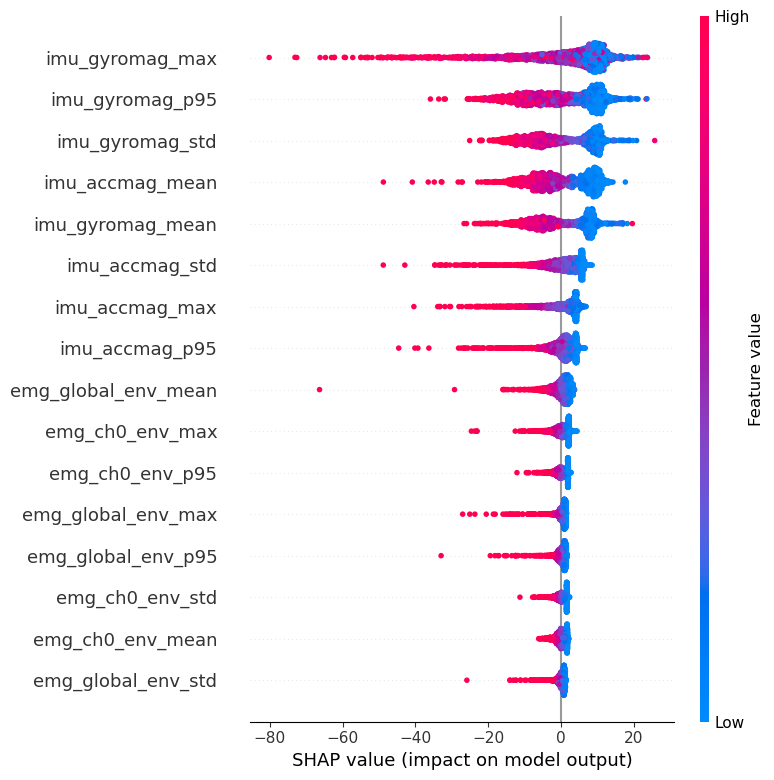

In [11]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ("svc", SVC(kernel="linear", probability=True))
])

pipe.fit(X, y)
explainer = shap.LinearExplainer(pipe.named_steps['svc'], X, feature_perturbation="correlation_dependent")

shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

In [12]:
# pipe = Pipeline([
#     ('scaler', StandardScaler()),
#     ("svc", SVC(kernel="rbf", probability=True))
# ])

# pipe.fit(X, y)

# X_scaled = pipe.named_steps["scaler"].transform(X)
# X_bg = shap.sample(X_scaled, 40, random_state=0)

# explainer = shap.KernelExplainer(pipe.named_steps["svc"].predict_proba, X_bg)
# shap_values = explainer.shap_values(X_bg)

# # shap.summary_plot(shap_values, X, feature_names=X.columns)
# shap.summary_plot(shap_values[1], X_bg, plot_type="dot", feature_names=X.columns)



No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


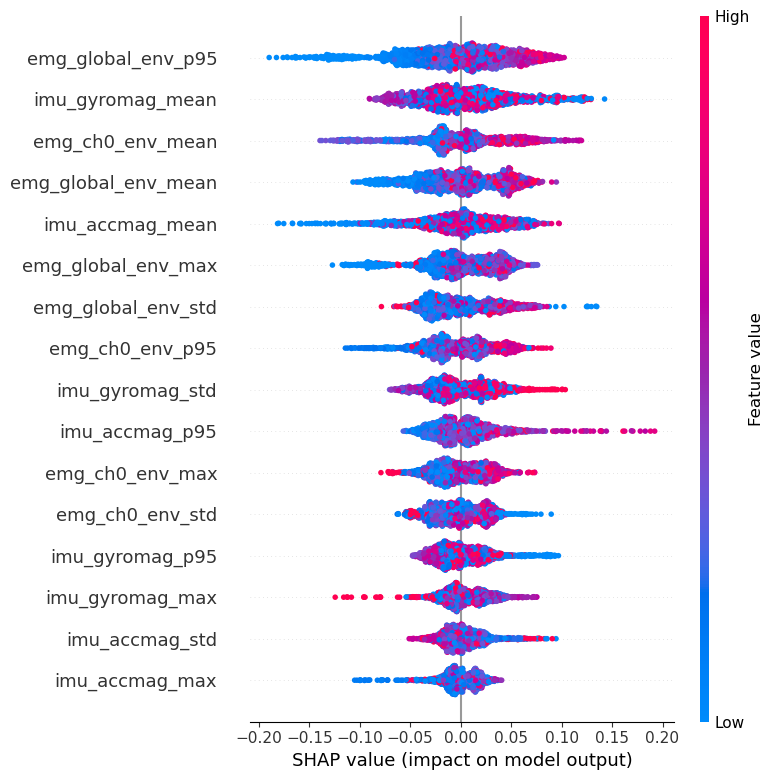

In [13]:
pipe = Pipeline([
    ("clf", RandomForestClassifier(n_estimators=300, random_state=42))
])

pipe.fit(X, y)

explainer = shap.TreeExplainer(pipe.named_steps["clf"])
shap_values = explainer.shap_values(X)

# shap.summary_plot(shap_values, X, feature_names=X.columns)
shap.summary_plot(shap_values[1], X, plot_type="dot")

In [14]:
results_loso_squat = run_loso(features_df_squat, models)
results_loso_squat

Subj 01 | LogReg → acc=0.294, f1=0.292, kappa=-0.342
Subj 01 | RF → acc=0.118, f1=0.118, kappa=-0.711
Subj 01 | SVM-linear → acc=0.294, f1=0.292, kappa=-0.342
Subj 01 | SVM-rbf → acc=0.353, f1=0.261, kappa=-0.120
Subj 02 | LogReg → acc=0.550, f1=0.436, kappa=0.100
Subj 02 | RF → acc=0.700, f1=0.670, kappa=0.400
Subj 02 | SVM-linear → acc=0.550, f1=0.436, kappa=0.100
Subj 02 | SVM-rbf → acc=0.500, f1=0.333, kappa=0.000
Subj 03 | LogReg → acc=0.455, f1=0.442, kappa=-0.021
Subj 03 | RF → acc=0.636, f1=0.607, kappa=0.227
Subj 03 | SVM-linear → acc=0.424, f1=0.388, kappa=-0.050
Subj 03 | SVM-rbf → acc=0.424, f1=0.366, kappa=-0.033
Subj 04 | LogReg → acc=0.550, f1=0.436, kappa=0.022
Subj 04 | RF → acc=0.550, f1=0.505, kappa=0.053
Subj 04 | SVM-linear → acc=0.550, f1=0.400, kappa=0.011
Subj 04 | SVM-rbf → acc=0.525, f1=0.344, kappa=-0.050
Subj 05 | LogReg → acc=0.564, f1=0.409, kappa=0.015
Subj 05 | RF → acc=0.256, f1=0.254, kappa=-0.444
Subj 05 | SVM-linear → acc=0.564, f1=0.409, kappa=0.015

,subject_left_out,model,accuracy,macro_f1,kappa
0,1,LogReg,0.294118,0.291667,-0.342105
1,1,RF,0.117647,0.117647,-0.711409
2,1,SVM-linear,0.294118,0.291667,-0.342105
3,1,SVM-rbf,0.352941,0.260870,-0.119760
4,2,LogReg,0.550000,0.435737,0.100000
...,...,...,...,...,...
119,30,SVM-rbf,0.666667,0.534161,0.152542
120,31,LogReg,0.718750,0.418182,-0.161290
121,31,RF,0.437500,0.376623,-0.028571
122,31,SVM-linear,0.687500,0.487179,0.000000


In [15]:
model_summary_squat = (
    results_loso_squat
    .groupby("model")
    .agg(
        n_subjects = ("subject_left_out", "nunique"),
        acc_mean   = ("accuracy", "mean"),
        acc_std    = ("accuracy", "std"),
        f1_mean    = ("macro_f1", "mean"),
        f1_std     = ("macro_f1", "std"),
        kappa_mean = ("kappa", "mean"),
        kappa_std  = ("kappa", "std"),
    )
    .reset_index()
)

model_summary_squat

,model,n_subjects,acc_mean,acc_std,f1_mean,f1_std,kappa_mean,kappa_std
0,LogReg,31,0.577361,0.117679,0.478443,0.117275,0.068321,0.184711
1,RF,31,0.529147,0.144459,0.457938,0.142159,0.030673,0.244947
2,SVM-linear,31,0.576364,0.132252,0.478315,0.134727,0.063311,0.217885
3,SVM-rbf,31,0.558164,0.157929,0.476001,0.161322,0.087920,0.245120


In [16]:
y_squat = features_df_squat["is_correct"]

forbidden_cols = [
    "exercise_id",
    "trial",
    "imu_len",
    "emg_len",
    "len_ratio_emg_imu",
    "imu_path",
    "emg_path",
    "imu_shape",
    "emg_shape",
    "imu_exists",
    "emg_exists",
]

X_squat= features_df_squat.drop(columns=["subject", "is_correct"] + forbidden_cols, errors="ignore")

print("features_df columns:", X_squat.columns.tolist())

features_df columns: ['imu_accmag_mean', 'imu_accmag_std', 'imu_accmag_max', 'imu_accmag_p95', 'imu_gyromag_mean', 'imu_gyromag_std', 'imu_gyromag_max', 'imu_gyromag_p95', 'emg_ch0_env_mean', 'emg_ch0_env_std', 'emg_ch0_env_max', 'emg_ch0_env_p95', 'emg_global_env_mean', 'emg_global_env_std', 'emg_global_env_max', 'emg_global_env_p95']


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


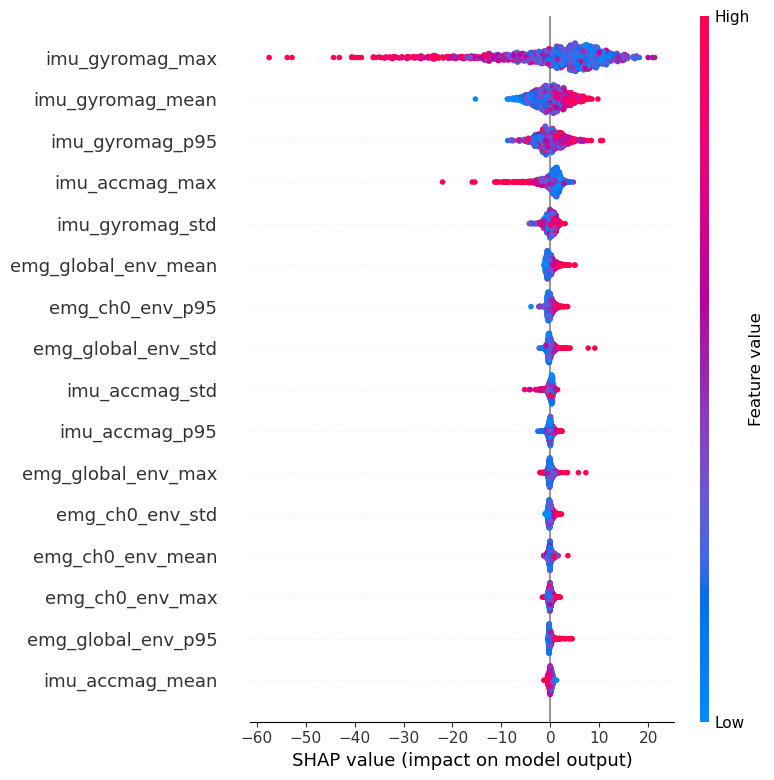

In [17]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ("svc", SVC(kernel="linear", probability=True))
])

pipe.fit(X_squat, y_squat)
explainer = shap.LinearExplainer(pipe.named_steps['svc'], X_squat, feature_perturbation="correlation_dependent")

shap_values = explainer.shap_values(X_squat)
shap.summary_plot(shap_values, X_squat)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


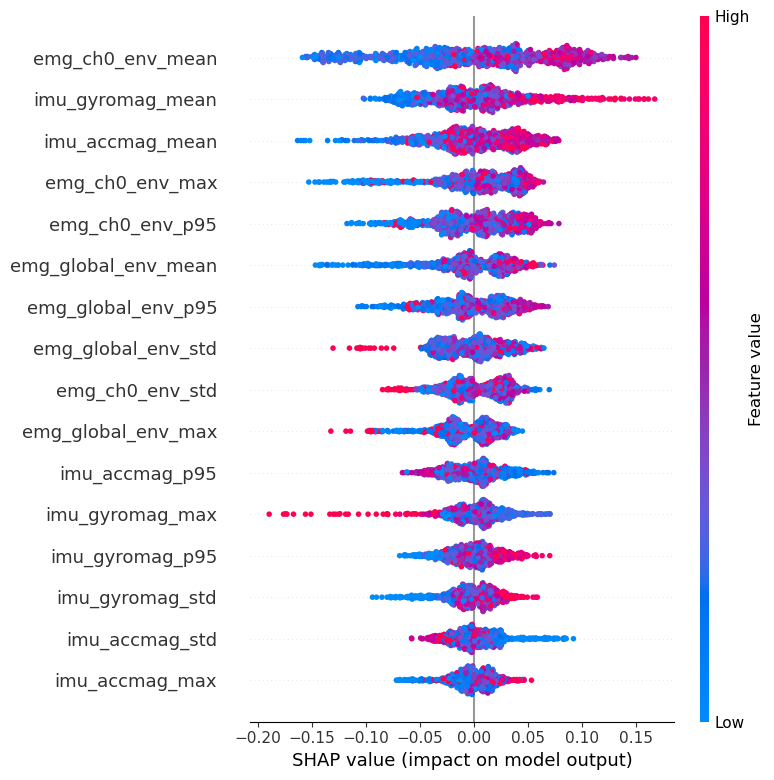

In [18]:
pipe = Pipeline([
    ("clf", RandomForestClassifier(n_estimators=300, random_state = 42))
])

pipe.fit(X_squat, y_squat)

explainer = shap.TreeExplainer(pipe.named_steps["clf"])
shap_values = explainer.shap_values(X_squat)

# shap.summary_plot(shap_values, X_squat, feature_names=X_squat.columns)
shap.summary_plot(shap_values[1], X_squat, plot_type="dot")

In [19]:
results_loso_sle = run_loso(features_df_sle, models)
results_loso_sle

Subj 01 | LogReg → acc=0.531, f1=0.520, kappa=0.084
Subj 01 | RF → acc=0.312, f1=0.267, kappa=-0.035
Subj 01 | SVM-linear → acc=0.531, f1=0.520, kappa=0.084
Subj 01 | SVM-rbf → acc=0.875, f1=0.845, kappa=0.692
Subj 02 | LogReg → acc=0.697, f1=0.411, kappa=0.000
Subj 02 | RF → acc=0.697, f1=0.411, kappa=0.000
Subj 02 | SVM-linear → acc=0.697, f1=0.411, kappa=0.000
Subj 02 | SVM-rbf → acc=0.697, f1=0.411, kappa=0.000
Subj 03 | LogReg → acc=0.788, f1=0.665, kappa=0.374
Subj 03 | RF → acc=0.727, f1=0.509, kappa=0.134
Subj 03 | SVM-linear → acc=0.727, f1=0.509, kappa=0.134
Subj 03 | SVM-rbf → acc=0.697, f1=0.411, kappa=0.000
Subj 04 | LogReg → acc=0.853, f1=0.786, kappa=0.585
Subj 04 | RF → acc=0.706, f1=0.414, kappa=0.000
Subj 04 | SVM-linear → acc=0.794, f1=0.667, kappa=0.377
Subj 04 | SVM-rbf → acc=0.706, f1=0.414, kappa=0.000
Subj 05 | LogReg → acc=0.833, f1=0.817, kappa=0.638
Subj 05 | RF → acc=0.500, f1=0.499, kappa=0.157
Subj 05 | SVM-linear → acc=0.833, f1=0.817, kappa=0.638
Subj 05

,subject_left_out,model,accuracy,macro_f1,kappa
0,1,LogReg,0.53125,0.519520,0.083969
1,1,RF,0.31250,0.266667,-0.035294
2,1,SVM-linear,0.53125,0.519520,0.083969
3,1,SVM-rbf,0.87500,0.845411,0.692308
4,2,LogReg,0.69697,0.410714,0.000000
...,...,...,...,...,...
111,30,SVM-rbf,0.71875,0.716256,0.474453
112,31,LogReg,0.75000,0.634286,0.304348
113,31,RF,0.71875,0.506003,0.132530
114,31,SVM-linear,0.81250,0.768116,0.538462


In [20]:
model_summary_sle = (
    results_loso_sle
    .groupby("model")
    .agg(
        n_subjects = ("subject_left_out", "nunique"),
        acc_mean   = ("accuracy", "mean"),
        acc_std    = ("accuracy", "std"),
        f1_mean    = ("macro_f1", "mean"),
        f1_std     = ("macro_f1", "std"),
        kappa_mean = ("kappa", "mean"),
        kappa_std  = ("kappa", "std"),
    )
    .reset_index()
)

model_summary_sle

,model,n_subjects,acc_mean,acc_std,f1_mean,f1_std,kappa_mean,kappa_std
0,LogReg,29,0.730044,0.148807,0.616746,0.207480,0.320535,0.333966
1,RF,29,0.690920,0.178923,0.561437,0.210523,0.236119,0.346826
2,SVM-linear,29,0.733878,0.147008,0.617616,0.210284,0.321613,0.342508
3,SVM-rbf,29,0.723397,0.117956,0.560932,0.199587,0.247249,0.313038


In [21]:
y_sle = features_df_sle["is_correct"]

forbidden_cols = [
    "exercise_id",
    "trial",
    "imu_len",
    "emg_len",
    "len_ratio_emg_imu",
    "imu_path",
    "emg_path",
    "imu_shape",
    "emg_shape",
    "imu_exists",
    "emg_exists",
]

X_sle= features_df_sle.drop(columns=["subject", "is_correct"] + forbidden_cols, errors="ignore")

print("features_df columns:", X_sle.columns.tolist())

features_df columns: ['imu_accmag_mean', 'imu_accmag_std', 'imu_accmag_max', 'imu_accmag_p95', 'imu_gyromag_mean', 'imu_gyromag_std', 'imu_gyromag_max', 'imu_gyromag_p95', 'emg_ch0_env_mean', 'emg_ch0_env_std', 'emg_ch0_env_max', 'emg_ch0_env_p95', 'emg_global_env_mean', 'emg_global_env_std', 'emg_global_env_max', 'emg_global_env_p95']


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


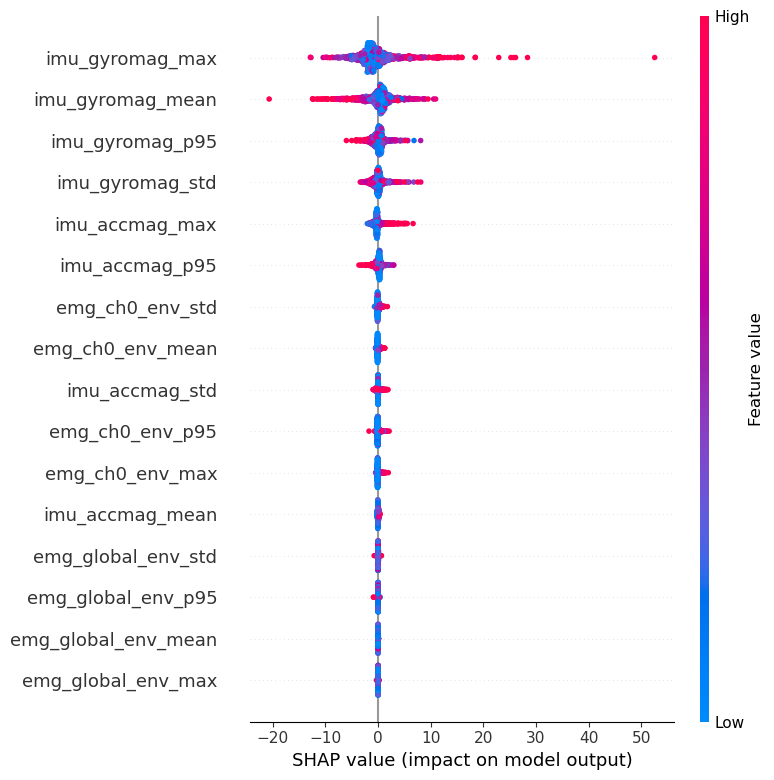

In [22]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ("svc", SVC(kernel="linear", probability=True))
])

pipe.fit(X_sle, y_sle)
explainer = shap.LinearExplainer(pipe.named_steps['svc'], X_sle, feature_perturbation="correlation_dependent")

shap_values = explainer.shap_values(X_sle)
shap.summary_plot(shap_values, X_sle)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


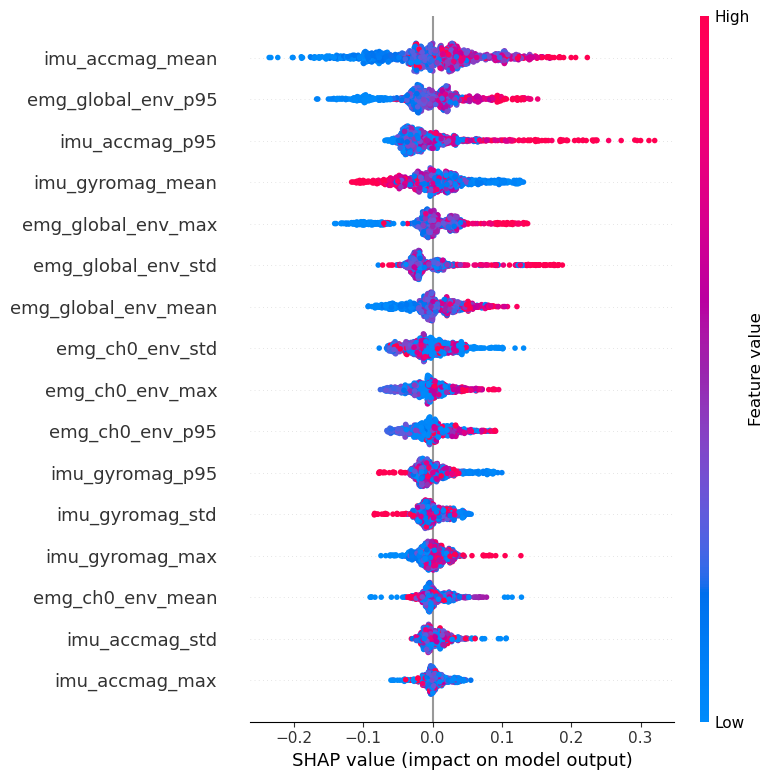

In [23]:
pipe_sle = Pipeline([
    ("clf", RandomForestClassifier(n_estimators=300, random_state=42))
])

pipe_sle.fit(X_sle, y_sle)

explainer = shap.TreeExplainer(pipe_sle.named_steps["clf"])
shap_values = explainer.shap_values(X_sle)

# shap.summary_plot(shap_values, X_sle, feature_names=X_sle.columns)
shap.summary_plot(shap_values[1], X_sle, plot_type="dot")

In [24]:
results_loso_walking = run_loso(features_df_walking, models)
results_loso_walking

Subj 01 | LogReg → acc=0.250, f1=0.200, kappa=0.000
Subj 01 | RF → acc=0.250, f1=0.200, kappa=0.000
Subj 01 | SVM-linear → acc=0.250, f1=0.200, kappa=0.000
Subj 01 | SVM-rbf → acc=0.250, f1=0.200, kappa=0.000
Subj 02 | LogReg → acc=0.000, f1=0.000, kappa=0.000
Subj 02 | RF → acc=0.000, f1=0.000, kappa=0.000
Subj 02 | SVM-linear → acc=0.000, f1=0.000, kappa=0.000
Subj 02 | SVM-rbf → acc=0.000, f1=0.000, kappa=0.000
Subj 03 | LogReg → acc=0.800, f1=0.762, kappa=0.545
Subj 03 | RF → acc=0.600, f1=0.375, kappa=0.000
Subj 03 | SVM-linear → acc=0.600, f1=0.375, kappa=0.000
Subj 03 | SVM-rbf → acc=0.600, f1=0.375, kappa=0.000
Subj 04 | LogReg → acc=1.000, f1=1.000, kappa=1.000
Subj 04 | RF → acc=1.000, f1=1.000, kappa=1.000
Subj 04 | SVM-linear → acc=1.000, f1=1.000, kappa=1.000
Subj 04 | SVM-rbf → acc=1.000, f1=1.000, kappa=1.000
Subj 05 | LogReg → acc=1.000, f1=1.000, kappa=1.000
Subj 05 | RF → acc=1.000, f1=1.000, kappa=1.000
Subj 05 | SVM-linear → acc=1.000, f1=1.000, kappa=1.000
Subj 05 

invalid value encountered in scalar divide
invalid value encountered in scalar divide
invalid value encountered in scalar divide
invalid value encountered in scalar divide


Subj 19 | RF → acc=1.000, f1=1.000, kappa=nan
Subj 19 | SVM-linear → acc=1.000, f1=1.000, kappa=nan
Subj 19 | SVM-rbf → acc=1.000, f1=1.000, kappa=nan
Subj 20 | LogReg → acc=0.750, f1=0.733, kappa=0.500
Subj 20 | RF → acc=1.000, f1=1.000, kappa=1.000
Subj 20 | SVM-linear → acc=1.000, f1=1.000, kappa=1.000
Subj 20 | SVM-rbf → acc=1.000, f1=1.000, kappa=1.000
Subj 21 | LogReg → acc=0.400, f1=0.286, kappa=0.000
Subj 21 | RF → acc=0.600, f1=0.583, kappa=0.286
Subj 21 | SVM-linear → acc=0.200, f1=0.167, kappa=-0.429
Subj 21 | SVM-rbf → acc=0.800, f1=0.762, kappa=0.545
Subj 22 | LogReg → acc=0.800, f1=0.800, kappa=0.615
Subj 22 | RF → acc=0.600, f1=0.583, kappa=0.286
Subj 22 | SVM-linear → acc=0.800, f1=0.800, kappa=0.615
Subj 22 | SVM-rbf → acc=0.800, f1=0.800, kappa=0.615
Subj 23 | LogReg → acc=0.667, f1=0.400, kappa=0.000
Subj 23 | RF → acc=0.667, f1=0.400, kappa=0.000
Subj 23 | SVM-linear → acc=0.667, f1=0.400, kappa=0.000
Subj 23 | SVM-rbf → acc=0.667, f1=0.400, kappa=0.000
Subj 24 | Lo

invalid value encountered in scalar divide


Subj 28 | RF → acc=0.500, f1=0.333, kappa=0.000
Subj 28 | SVM-linear → acc=1.000, f1=1.000, kappa=nan
Subj 28 | SVM-rbf → acc=0.000, f1=0.000, kappa=0.000
Subj 29 | LogReg → acc=0.667, f1=0.400, kappa=0.000


invalid value encountered in scalar divide


Subj 29 | RF → acc=0.667, f1=0.400, kappa=0.000
Subj 29 | SVM-linear → acc=0.667, f1=0.400, kappa=0.000
Subj 29 | SVM-rbf → acc=0.667, f1=0.400, kappa=0.000
Subj 30 | LogReg → acc=0.500, f1=0.333, kappa=0.000
Subj 30 | RF → acc=1.000, f1=1.000, kappa=1.000
Subj 30 | SVM-linear → acc=0.500, f1=0.333, kappa=0.000
Subj 30 | SVM-rbf → acc=1.000, f1=1.000, kappa=1.000
Subj 31 | LogReg → acc=0.667, f1=0.400, kappa=0.000
Subj 31 | RF → acc=0.667, f1=0.400, kappa=0.000
Subj 31 | SVM-linear → acc=0.667, f1=0.400, kappa=0.000
Subj 31 | SVM-rbf → acc=0.667, f1=0.400, kappa=0.000


,subject_left_out,model,accuracy,macro_f1,kappa
0,1,LogReg,0.250000,0.2,0.0
1,1,RF,0.250000,0.2,0.0
2,1,SVM-linear,0.250000,0.2,0.0
3,1,SVM-rbf,0.250000,0.2,0.0
4,2,LogReg,0.000000,0.0,0.0
...,...,...,...,...,...
107,30,SVM-rbf,1.000000,1.0,1.0
108,31,LogReg,0.666667,0.4,0.0
109,31,RF,0.666667,0.4,0.0
110,31,SVM-linear,0.666667,0.4,0.0


In [25]:
model_summary_walking = (
    results_loso_walking
    .groupby("model")
    .agg(
        n_subjects = ("subject_left_out", "nunique"),
        acc_mean   = ("accuracy", "mean"),
        acc_std    = ("accuracy", "std"),
        f1_mean    = ("macro_f1", "mean"),
        f1_std     = ("macro_f1", "std"),
        kappa_mean = ("kappa", "mean"),
        kappa_std  = ("kappa", "std"),
    )
    .reset_index()
)

model_summary_walking

,model,n_subjects,acc_mean,acc_std,f1_mean,f1_std,kappa_mean,kappa_std
0,LogReg,28,0.742857,0.291563,0.668027,0.335665,0.465627,0.447067
1,RF,28,0.714881,0.286936,0.631477,0.330677,0.425493,0.448035
2,SVM-linear,28,0.725595,0.303494,0.647577,0.344717,0.424318,0.479529
3,SVM-rbf,28,0.726190,0.315916,0.657270,0.351276,0.484305,0.451154


In [26]:
y_walking = features_df_walking["is_correct"]

forbidden_cols = [
    "exercise_id",
    "trial",
    "imu_len",
    "emg_len",
    "len_ratio_emg_imu",
    "imu_path",
    "emg_path",
    "imu_shape",
    "emg_shape",
    "imu_exists",
    "emg_exists",
]

X_walking= features_df_walking.drop(columns=["subject", "is_correct"] + forbidden_cols, errors="ignore")

print("features_df columns:", X_walking.columns.tolist())

features_df columns: ['imu_accmag_mean', 'imu_accmag_std', 'imu_accmag_max', 'imu_accmag_p95', 'imu_gyromag_mean', 'imu_gyromag_std', 'imu_gyromag_max', 'imu_gyromag_p95', 'emg_ch0_env_mean', 'emg_ch0_env_std', 'emg_ch0_env_max', 'emg_ch0_env_p95', 'emg_global_env_mean', 'emg_global_env_std', 'emg_global_env_max', 'emg_global_env_p95']


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


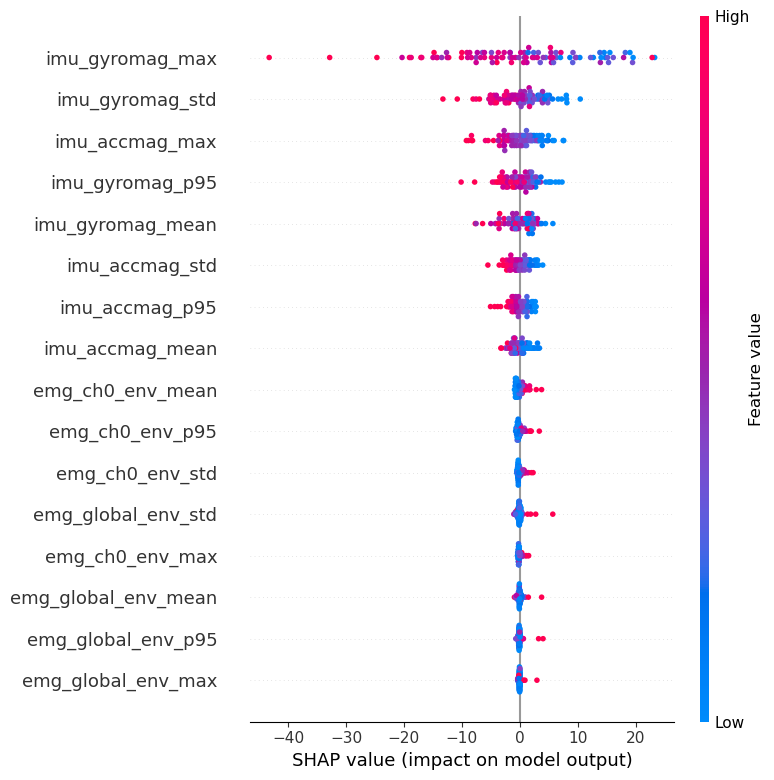

In [27]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ("svc", SVC(kernel="linear", probability=True))
])

pipe.fit(X_walking, y_walking)
explainer = shap.LinearExplainer(pipe.named_steps['svc'], X_walking, feature_perturbation="correlation_dependent")

shap_values = explainer.shap_values(X_walking)
shap.summary_plot(shap_values, X_walking)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


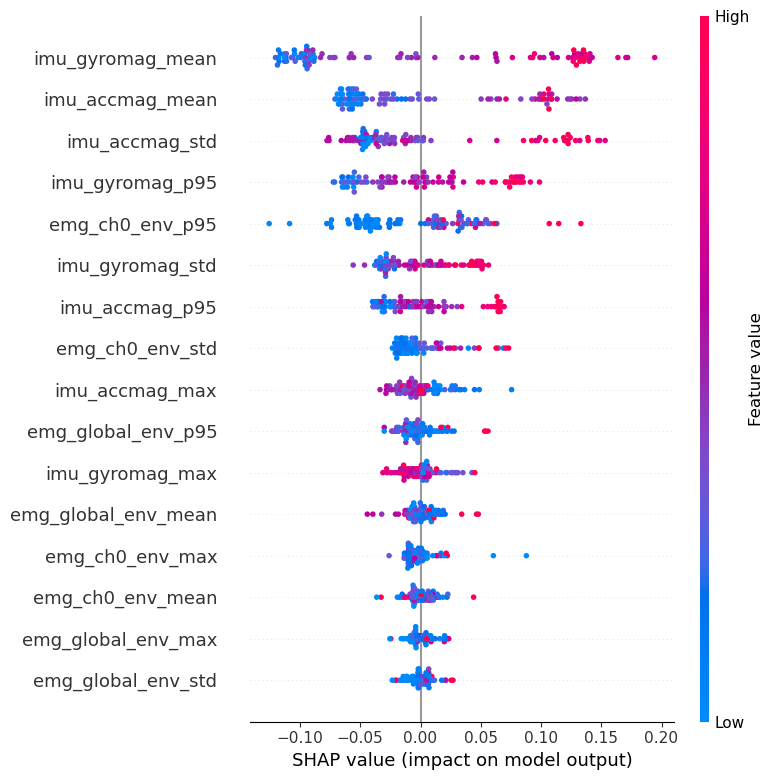

In [28]:
pipe = Pipeline([
    ("clf", RandomForestClassifier(n_estimators=300, random_state = 42))
])

pipe.fit(X_walking, y_walking)

explainer = shap.TreeExplainer(pipe.named_steps["clf"])
shap_values = explainer.shap_values(X_walking)

# shap.summary_plot(shap_values, X_walking, feature_names=X_walking.columns)
shap.summary_plot(shap_values[1], X_walking, plot_type="dot")